In [1]:
# import clawpack_annular as cpa

In [2]:
from clawpack import riemann

In [3]:
import matplotlib.pyplot as plt

In [4]:
# %matplotlib notebook

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
from clawpack import pyclaw
from clawpack.pyclaw.examples.advection_2d_annulus.mapc2p import mapc2p

import numpy as np
# from clawpack.visclaw import colormaps

In [24]:
import re

Use parts of `run_app_from_main` below (https://github.com/clawpack/pyclaw/blob/151aefa92a613d952f3b49070cd80826a81b1178/src/pyclaw/util.py#L83)

In [7]:
# these are usually passed to setup function.
pyclaw_kwargs = {'use_petsc':False,
                'outdir':'./_output',
                'solver_type':'classic'}

Solver options to check?

```
solver = pyclaw.ClawSolver2D(riemann.vc_advection_2D)
solver.dimensional_split = False
solver.transverse_waves = 2
solver.order = 2
```

In [8]:
# clawSolution = cpa.setup()

# status = clawSolution.run()
# status

In [9]:
# clawSolution.viewable_attributes

In [10]:
# clawSolution.solver.cfl.get_cached_max()

In [11]:
# outdir = pyclaw_kwargs.get('outdir','./_output')
# htmlplot = pyclaw_kwargs.get('htmlplot',False) # return False if key doesn't exist
# iplot    = pyclaw_kwargs.get('iplot',False)
# outdir, htmlplot, iplot

In [12]:
# pyclaw.plot.html_plot(outdir=outdir,setplot=cpa.setplot)

**Plotting (`pyclaw.plot.html_plot`)** - (https://github.com/clawpack/pyclaw/blob/master/src/pyclaw/plot.py)

Conversion to curvilinear coordinates?

In [13]:
r_lower = 0.2
r_upper = 1.0
m_r = 40

theta_lower = 0.0
theta_upper = np.pi*2.0
m_theta = 120

In [14]:
def mapc2p_annulus(xc, yc):
    """
    Specifies the mapping to curvilinear coordinates.

    Inputs: c_centers = Computational cell centers
                 [array ([Xc1, Xc2, ...]), array([Yc1, Yc2, ...])]

    Output: p_centers = Physical cell centers
                 [array ([Xp1, Xp2, ...]), array([Yp1, Yp2, ...])]
    """  
    p_centers = []

    # Polar coordinates (first coordinate = radius,  second coordinate = theta)
    p_centers.append(xc[:]*np.cos(yc[:]))
    p_centers.append(xc[:]*np.sin(yc[:]))
    
    return p_centers


In [15]:
# solver = pyclaw.ClawSolver2D(riemann.vc_advection_2D)
# solver.dimensional_split = False
# solver.transverse_waves = 2
# solver.order = 2

# # solver.bc_lower[0] = pyclaw.BC.extrap
# # solver.bc_upper[0] = pyclaw.BC.extrap
# # solver.bc_lower[1] = pyclaw.BC.periodic
# # solver.bc_upper[1] = pyclaw.BC.periodic

# # solver.aux_bc_lower[0] = pyclaw.BC.custom
# # solver.aux_bc_upper[0] = pyclaw.BC.custom
# # solver.user_aux_bc_lower = ghost_velocities_lower
# # solver.user_aux_bc_upper = ghost_velocities_upper
# # solver.aux_bc_lower[1] = pyclaw.BC.periodic
# # solver.aux_bc_upper[1] = pyclaw.BC.periodic

# solver.dt_initial = 0.1
# solver.cfl_max = 0.5
# solver.cfl_desired = 0.4

# solver.limiters = pyclaw.limiters.tvd.vanleer

# r     = pyclaw.Dimension(r_lower,r_upper,m_r,name='r')
# theta = pyclaw.Dimension(theta_lower,theta_upper,m_theta,name='theta')
# domain = pyclaw.Domain([r,theta])
# domain.grid.mapc2p = mapc2p_annulus
# domain.grid.num_ghost = solver.num_ghost

Based on the above functionality, interpolate Cartesian data to each cell for initial state defn? Here we will also need to specify the number of cells that will get mapped (we can create a grid first, obtain cell centers from it and use those for interpolation purposes)

For now load an example file in $pixel value -\theta$ coordinates, and map it appropriately.

In [16]:
def Polar_to_Cartesian(edge, start_angle, end_angle, height, width, circles_disk, circles_scope):
    theta = np.arange(0, 2 * np.pi, 2 * np.pi / width)[start_angle:end_angle]
    # Coordinates of disk and telescope center
    circle_x = circles_disk[0]
    circle_y = circles_disk[1]
    # Radius of disk and telescope
    r_disk = circles_disk[2]
    r_scope = circles_scope[2]
    Xp = circle_x + r_disk * np.cos(theta + 1.2 * np.pi)
    Yp = circle_y + r_disk * np.sin(theta + 1.2 * np.pi)
    Xi = circle_x + r_scope * np.cos(theta + 1.2 * np.pi)
    Yi = circle_y + r_scope * np.sin(theta + 1.2 * np.pi)
    r = edge / height
    X = Xp + ( Xi - Xp ) * r
    Y = Yp + ( Yi - Yp ) * r
    return (X,Y)

In [17]:
raw_data = np.load("/home/ajivani/WLROM_new/WhiteLight/validation_data/CR2161_validation_PolarTensor.npy")
raw_data.shape

(128, 512, 90, 23)

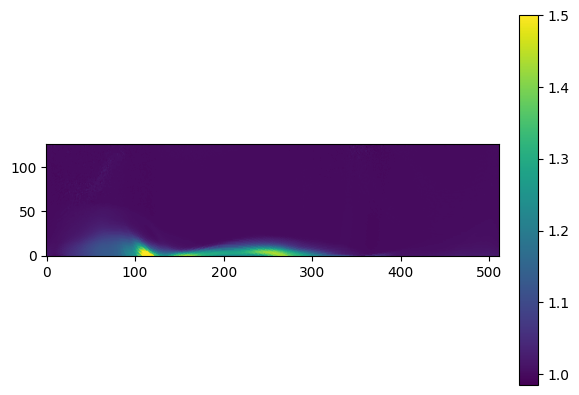

In [18]:
sample_rd = raw_data[:126, :, 25, 20]
# print(sample_rd.shape)
im = plt.imshow(sample_rd,
           cmap="viridis",
          origin="lower")
# plt.show()
plt.colorbar(im, fraction=0.046, pad=0.04)

In [62]:
sample_rd.shape

(126, 512)

In [19]:
raw_data[:126, :, :, :].min(), raw_data[:126, :, :, :].max()

(0.9175531085896761, 1.5)

In [20]:
circles_disk = (149, 149, 19)
circles_scope = (149, 149, 110)

theta_s_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360
theta_e_2161 = np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360


# nTimes, nThetas = edges_sim.shape[0], edges_sim.shape[1]
    
# r_vals = np.zeros((nTimes, nThetas))
# theta_vals = np.zeros((nTimes, nThetas))

# for i in range(nTimes):
#     xi, yi   = Polar_to_Cartesian(edges_sim[i, :], 
#                start_angle = 160, 
#                end_angle = 320, 
#                height=128, 
#                width=512, 
#                circles_disk=(149,149,19), 
#                circles_scope=(149,149,110),
#                sample_freq=sample_freq)
        

In [40]:
height=128
width=512
X_coords = np.zeros((512, 126))
Y_coords = np.zeros((512, 126))

X_coords_norm = np.zeros((512, 126))
Y_coords_norm = np.zeros((512, 126))
for i in range(126):
    theta = np.arange(0, 2 * np.pi, 2 * np.pi / width)
    circle_x = circles_disk[0]
    circle_y = circles_disk[1]
    # Radius of disk and telescope
    r_disk = circles_disk[2]
    r_scope = circles_scope[2]
    Xp = circle_x + r_disk * np.cos(theta + 1.2 * np.pi)
    Yp = circle_y + r_disk * np.sin(theta + 1.2 * np.pi)
    Xi = circle_x + r_scope * np.cos(theta + 1.2 * np.pi)
    Yi = circle_y + r_scope * np.sin(theta + 1.2 * np.pi)
    
    
#     r = sample_rd[i, :] / height
    r = (i + 1) / height # pixel values
    X = Xp + ( Xi - Xp ) * r
    Y = Yp + ( Yi - Yp ) * r
    
    X_coords[:, i] = X
    Y_coords[:, i] = Y
    
    X_coords_norm[:, i] = 64 * (X_coords[:, i]/300) - 32
    Y_coords_norm[:, i] = 64 * (Y_coords[:, i]/300) - 32    

In [22]:
def Polar_to_Cartesian(edge, start_angle, end_angle, height, width, circles_disk, circles_scope):
    theta = np.arange(0, 2 * np.pi, 2 * np.pi / width)[start_angle:end_angle]
    # Coordinates of disk and telescope center
    circle_x = circles_disk[0]
    circle_y = circles_disk[1]
    # Radius of disk and telescope
    r_disk = circles_disk[2]
    r_scope = circles_scope[2]
    Xp = circle_x + r_disk * np.cos(theta + 1.2 * np.pi)
    Yp = circle_y + r_disk * np.sin(theta + 1.2 * np.pi)
    Xi = circle_x + r_scope * np.cos(theta + 1.2 * np.pi)
    Yi = circle_y + r_scope * np.sin(theta + 1.2 * np.pi)
    r = edge / height
    X = Xp + ( Xi - Xp ) * r
    Y = Yp + ( Yi - Yp ) * r
    return (X,Y)

def getRValues(edge_data_matrix, simIdx=0, minStartIdx=0):
    
    edges_sim = edge_data_matrix[minStartIdx:, :, simIdx]
    
    nTimes, nThetas = edges_sim.shape[0], edges_sim.shape[1]
    
    r_vals = np.zeros((nTimes, nThetas))
    theta_vals = np.zeros((nTimes, nThetas))
    
    for i in range(nTimes):
        xi, yi   = Polar_to_Cartesian(edges_sim[i, :], 
                   start_angle = 160, 
                   end_angle = 320, 
                   height=128, 
                   width=512, 
                   circles_disk=(149,149,19), 
                   circles_scope=(149,149,110),
                   )
        
        xi_norm, yi_norm = 64 * (xi/300) - 32, 64 * (yi/300) - 32
        theta_vals[i, :] = np.arctan2(yi_norm, xi_norm)
    
        r_vals[i, :] = np.sqrt(xi_norm**2 + yi_norm**2)
    
    return r_vals, theta_vals

def load_edge_data_blobfree(eventID):
    edge_data = np.load("../WLROM_new/WhiteLight/edge_data/CR{}_stacked_edge_blobfree.npy".format(eventID))
    simID_data = np.load("../WLROM_new/WhiteLight/edge_data/CR{}_SimID4edge.npy".format(eventID))
    
    all_sims = []
    
    for s in simID_data:
        mm = re.search("run\d\d\d_AWSoM2T", s)
        all_sims.append(int(mm.group().split("run")[1].split("_")[0]))
    
    return edge_data, np.array(all_sims)

In [28]:
ed_2161, sd_2161 = load_edge_data_blobfree(2161)
r_vals, theta_vals = getRValues(ed_2161, simIdx=0, minStartIdx=0)

In [32]:
ed_2161.shape, r_vals.shape

((90, 160, 278), (90, 160))

In [36]:
r_vals.min(), r_vals.max()

(3.751635421809057, 22.908022477488224)

In [33]:
r_data_matrix = np.zeros(ed_2161.shape)
nsims = ed_2161.shape[2]
for i in range(nsims):
    r_vals_sim, theta_vals_sim = getRValues(ed_2161, simIdx=i, minStartIdx=0)
    r_data_matrix[:, :, i] = r_vals_sim

In [37]:
r_data_matrix.min(), r_data_matrix.max() # use these as reference.

(3.751635421809057, 23.398075609790858)

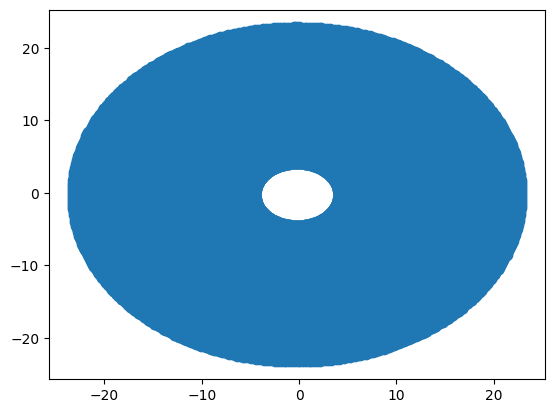

In [41]:
plt.scatter(X_coords_norm, Y_coords_norm)

In [38]:
X_coords.shape, Y_coords.shape

((512, 126), (512, 126))

In [54]:
R_coords

array([[ 4.50323181,  4.65489041,  4.80654953, ..., 23.15803257,
        23.30969893, 23.46136528],
       [ 4.50375164,  4.65541145,  4.80707169, ..., 23.15858213,
        23.31024853, 23.46191494],
       [ 4.50422944,  4.65589035,  4.80755164, ..., 23.1590873 ,
        23.31075374, 23.46242019],
       ...,
       [ 4.50142078,  4.65307521,  4.80473042, ..., 23.15611837,
        23.30778456, 23.45945076],
       [ 4.50206631,  4.65372222,  4.80537882, ..., 23.1568006 ,
        23.30846685, 23.46013311],
       [ 4.50267001,  4.65432732,  4.80598522, ..., 23.1574387 ,
        23.309105  , 23.46077131]])

In [55]:
R_coords.min()

3.903302085636277

In [56]:
R_coords.max()

23.465031329617336

In [89]:
np.tile(R_coords[0, :], (512, 1)).T.shape

(126, 512)

In [90]:
sample_rd.T.shape

(512, 126)

/tmp/ipykernel_3833062/2048717324.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  contour = ax.pcolormesh(xxx, yyy, np.tile(R_coords[0, :], (512, 1)), shading='auto')


Text(0.5, 1.0, 'Data on Cartesian Grid')

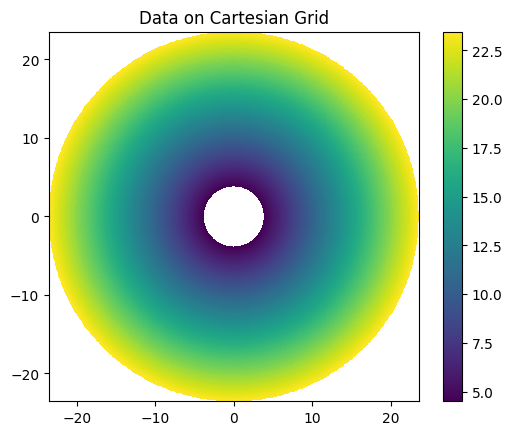

In [91]:
rr = np.linspace(R_coords.min(), R_coords.max(), 126)
tt = np.linspace(0, 2 * np.pi, 512)

rrm, ttm = np.meshgrid(rr, tt)

data = np.random.rand(512, 126)
# import matplotlib.pyplot as plt
# ax = plt.subplot(111, polar=True)
# ax.plot(ttm, rrm, color='r', ls='none', marker='.')

xxx = rrm * np.cos(ttm)
yyy = rrm * np.sin(ttm)

# fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
# levels = np.linspace(data.min(), data.max(), 20)  # Adjust the number of levels as needed
# contour = ax.contourf(ttm, rrm, data, levels=levels)
# fig.colorbar(contour)
# ax.set_title('Data on Polar Grid')

# Plot the data on a Cartesian grid
fig, ax = plt.subplots()
# levels = np.linspace(data.min(), data.max(), 20)  # Adjust the number of levels as needed
# contour = ax.pcolormesh(xxx, yyy, data, shading='auto')
contour = ax.pcolormesh(xxx, yyy, np.tile(R_coords[0, :], (512, 1)), shading='auto')
fig.colorbar(contour)
ax.set_aspect('equal')  # Ensure equal aspect ratio for circles
ax.set_title('Data on Cartesian Grid')

/tmp/ipykernel_3833062/1378040933.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  contour = ax.pcolormesh(xxx, yyy, sample_rd.T, shading='auto')


Text(0.5, 1.0, 'Data on Cartesian Grid')

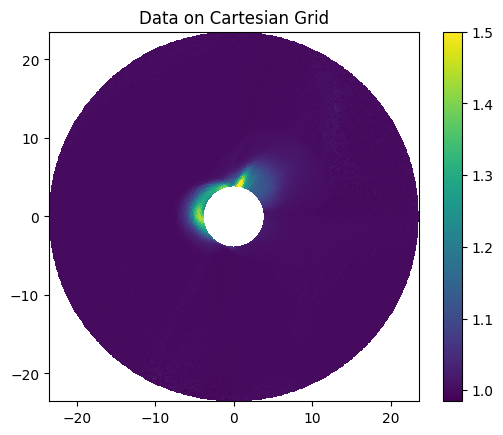

In [63]:
fig, ax = plt.subplots()
# levels = np.linspace(data.min(), data.max(), 20)  # Adjust the number of levels as needed
contour = ax.pcolormesh(xxx, yyy, sample_rd.T, shading='auto')
fig.colorbar(contour)
ax.set_aspect('equal')  # Ensure equal aspect ratio for circles
ax.set_title('Data on Cartesian Grid')

In [64]:
raw_data.shape

(128, 512, 90, 23)

/tmp/ipykernel_3833062/769523301.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  contour = ax.pcolormesh(xxx, yyy, raw_data[:126, :, 69, 20].T, shading='auto')


Text(0.5, 1.0, 'Data on Cartesian Grid')

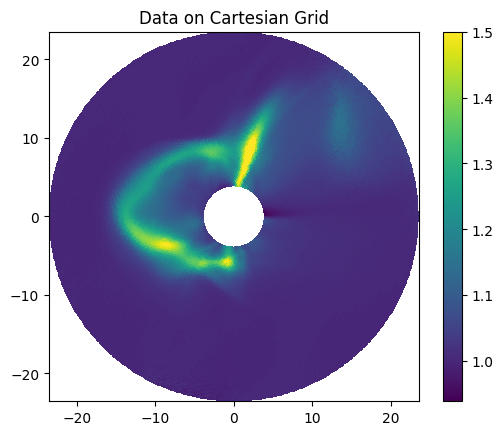

In [67]:
fig, ax = plt.subplots()
# levels = np.linspace(data.min(), data.max(), 20)  # Adjust the number of levels as needed
contour = ax.pcolormesh(xxx, yyy, raw_data[:126, :, 69, 20].T, shading='auto')
fig.colorbar(contour)
ax.set_aspect('equal')  # Ensure equal aspect ratio for circles
ax.set_title('Data on Cartesian Grid')

/tmp/ipykernel_3833062/3371450912.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  contour = ax.pcolormesh(xxx, yyy, raw_data[:126, :, 89, 20].T, shading='auto')


Text(0.5, 1.0, 'Data on Cartesian Grid')

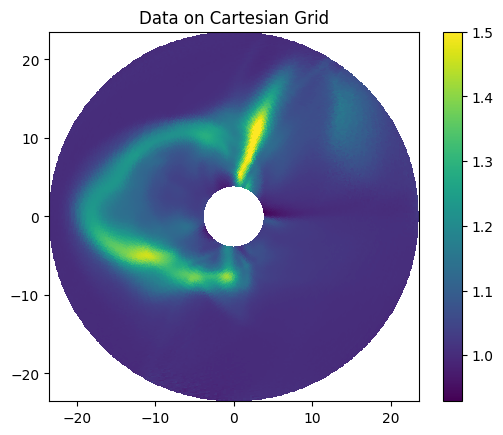

In [71]:
fig, ax = plt.subplots()
# levels = np.linspace(data.min(), data.max(), 20)  # Adjust the number of levels as needed
contour = ax.pcolormesh(xxx, yyy, raw_data[:126, :, 89, 20].T, shading='auto')
fig.colorbar(contour)
ax.set_aspect('equal')  # Ensure equal aspect ratio for circles
ax.set_title('Data on Cartesian Grid')

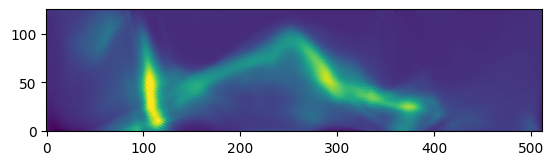

In [73]:
plt.imshow(raw_data[:126, :, 89, 20],
          origin="lower")

In [53]:
R_coords = np.sqrt(X_coords_norm**2 + Y_coords_norm**2)

In [39]:
thetaFinal = np.arange(0, 2 * np.pi, 2 * np.pi / width)
thetaFinal.shape

(512,)

In [ ]:
X_coords[]

In [23]:
# Now get the real r values for every theta from corresponding X and Y.
# rInner = 3.7516
# rOuter = 23.3981




In [ ]:
# what were the x and theta that gave rise to these?

In [ ]:
# do for a single sim and verify with plot that the rearrangement is correct? 
# derive pixel coordinates.

nTimes, nThetas = edges_sim.shape[0], edges_sim.shape[1]
    
r_vals = np.zeros((nTimes, nThetas))
theta_vals = np.zeros((nTimes, nThetas))

for i in range(nTimes):
    xi, yi   = Polar_to_Cartesian(edges_sim[i, :], 
               start_angle = 160, 
               end_angle = 320, 
               height=128, 
               width=512, 
               circles_disk=(149,149,19), 
               circles_scope=(149,149,110),
               sample_freq=sample_freq)
        

In [ ]:
def Polar_to_Cartesian(edge, start_angle, end_angle, height, width, circles_disk, circles_scope):
    theta = np.arange(0, 2 * np.pi, 2 * np.pi / width)[start_angle:end_angle:sample_freq]
    # Coordinates of disk and telescope center                                                                                                                                                        
    circle_x = circles_disk[0]
    circle_y = circles_disk[1]
    # Radius of disk and telescope                                                                                                                                                                    
    r_disk = circles_disk[2]
    r_scope = circles_scope[2]
    Xp = circle_x + r_disk * np.cos(theta + 1.2 * np.pi)
    Yp = circle_y + r_disk * np.sin(theta + 1.2 * np.pi)
    Xi = circle_x + r_scope * np.cos(theta + 1.2 * np.pi)
    Yi = circle_y + r_scope * np.sin(theta + 1.2 * np.pi)
    r = edge / height
    X = Xp + ( Xi - Xp ) * r
    Y = Yp + ( Yi - Yp ) * r
    return (X,Y)

In [ ]:
domain.grid.num_ghost

In [ ]:
domain.grid

In [ ]:
domain.grid.num_dim

In [ ]:
domain.grid.num_cells

In [ ]:
domain.grid.lower

In [ ]:
domain.grid.delta

In [ ]:
# fig, ax = plt.subplots()
# ax = domain.grid.plot()
# fig

In [51]:
rrm

array([[1.15      , 1.35263158, 1.55526316, 1.75789474, 1.96052632,
        2.16315789, 2.36578947, 2.56842105, 2.77105263, 2.97368421,
        3.17631579, 3.37894737, 3.58157895, 3.78421053, 3.98684211,
        4.18947368, 4.39210526, 4.59473684, 4.79736842, 5.        ],
       [1.15      , 1.35263158, 1.55526316, 1.75789474, 1.96052632,
        2.16315789, 2.36578947, 2.56842105, 2.77105263, 2.97368421,
        3.17631579, 3.37894737, 3.58157895, 3.78421053, 3.98684211,
        4.18947368, 4.39210526, 4.59473684, 4.79736842, 5.        ],
       [1.15      , 1.35263158, 1.55526316, 1.75789474, 1.96052632,
        2.16315789, 2.36578947, 2.56842105, 2.77105263, 2.97368421,
        3.17631579, 3.37894737, 3.58157895, 3.78421053, 3.98684211,
        4.18947368, 4.39210526, 4.59473684, 4.79736842, 5.        ],
       [1.15      , 1.35263158, 1.55526316, 1.75789474, 1.96052632,
        2.16315789, 2.36578947, 2.56842105, 2.77105263, 2.97368421,
        3.17631579, 3.37894737, 3.58157895, 3

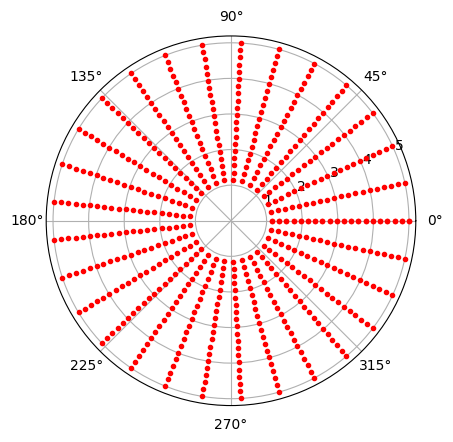

In [48]:
RR = 1.15
rr = np.linspace(RR,5,20)
tt = np.linspace(0,2*np.pi,30)

rrm, ttm = np.meshgrid(rr, tt)

xxx = rrm * np.cos(ttm)
yyy = rrm * np.sin(ttm)

import matplotlib.pyplot as plt
ax = plt.subplot(111, polar=True)
ax.plot(ttm, rrm, color='r', ls='none', marker='.')

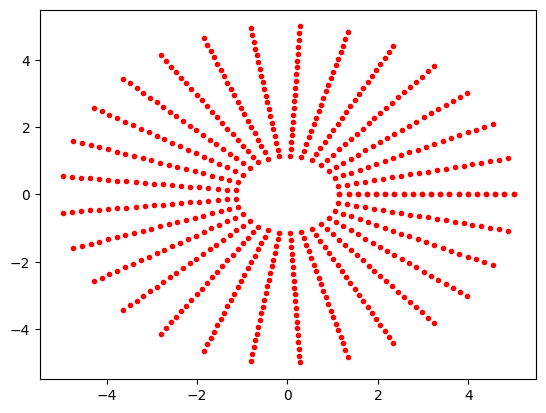

In [49]:
plt.plot(xxx, yyy, 'r. ')
plt.show()